In [14]:
import pandas as pd
import numpy as np
from mido import MidiFile
import pygame
import IPython
import matplotlib.pyplot as plt
import librosa.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split

from IPython import *
from music21 import *

import os

In [3]:
path = "./musicnet_dataset/musicnet_midis/musicnet_midis/Beethoven/"

note_on=[]
n=50
for m in range(n):
    mid=MidiFile(path+os.listdir(path)[m],clip=True)
    for j in range(len(mid.tracks)):
        for i in mid.tracks[j] :
            if str(type(i))!="<class 'mido.midifiles.meta.MetaMessage'>" :
                x=str(i).split(' ')
                if x[0]=='note_on':
                    note_on.append(int(x[2].split('=')[1]))

In [5]:
len(note_on)

235667

In [6]:
train_data = []
labels = []

for i in range(20, len(note_on)):
    train_data.append(note_on[i-20:i])
    labels.append(note_on[i])

In [8]:
train_data[0]

[69,
 63,
 64,
 72,
 71,
 80,
 81,
 83,
 84,
 84,
 83,
 75,
 76,
 77,
 77,
 76,
 74,
 77,
 74,
 72]

In [9]:
labels[0]

71

In [24]:
model = Sequential()
model.add(LSTM(200, input_shape=(20, 1), unroll=True, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(100))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="relu"))

In [25]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.MeanSquaredError()
)

In [17]:
train_data = np.array(train_data)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
labels = np.array(labels)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.05, random_state=42)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((223864, 20, 1), (223864,), (11783, 20, 1), (11783,))

In [26]:
with tf.device("/device:GPU:0"):
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)

Epoch 1/5
6996/6996 [==============================] - 142s 20ms/step - loss: 76.1917 - val_loss: 48.9977
Epoch 2/5
6996/6996 [==============================] - 137s 20ms/step - loss: 48.0775 - val_loss: 44.8833
Epoch 3/5
6996/6996 [==============================] - 137s 20ms/step - loss: 44.8081 - val_loss: 43.1304
Epoch 4/5
6996/6996 [==============================] - 138s 20ms/step - loss: 43.1416 - val_loss: 41.2367
Epoch 5/5
6996/6996 [==============================] - 140s 20ms/step - loss: 42.0242 - val_loss: 44.7546


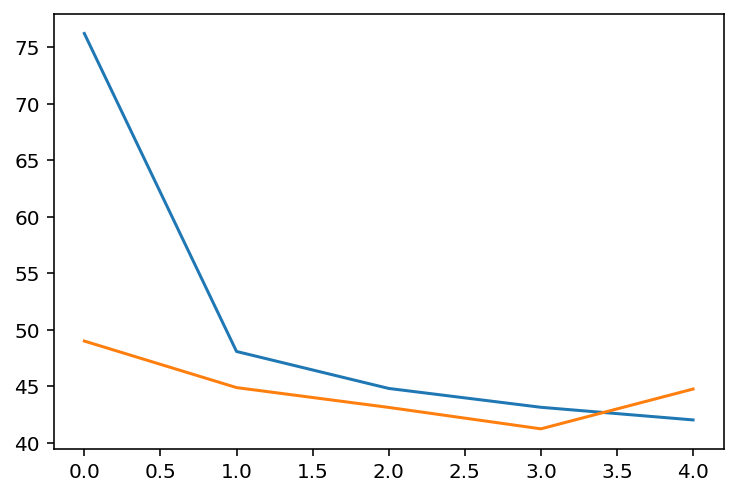

In [27]:
history=model.history.history
plt.plot([i for i in range(len(history['loss']))],history['loss'])
plt.plot([i for i in range(len(history['val_loss']))],history['val_loss'])

In [28]:
pred = model.predict(train_data[0].reshape(1, 20, 1))

In [29]:
pred

array([[70.27736]], dtype=float32)

In [31]:
pred[0][0]

70.27736

In [49]:
n=200
starter_notes=train_data[0]
x=train_data[0].reshape(1,20,1)
tune=list(train_data[0].reshape(-1,))

for i in range(n) :
    pred=int(model.predict(x)[0][0])
    if round(pred)==round(tune[-1]):
        p=np.random.choice(['a','b','c'])
        if p=='a':
            pred=65
        elif p=='b':
            pred=60
        else:
            pred=70
    tune.append(pred)

In [52]:
x = tune[-10:]
x = np.array(x)
x = x.reshape(1, 10, 1)

In [53]:
tune=list(np.array(tune).astype('float32'))

In [54]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for patterns in tune:
    pattern=str(patterns)
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [55]:
output_notes

[<music21.chord.Chord A4 C>,
 <music21.chord.Chord E-4 C>,
 <music21.chord.Chord E4 C>,
 <music21.chord.Chord C5 C>,
 <music21.chord.Chord B4 C>,
 <music21.chord.Chord G#5 C>,
 <music21.chord.Chord A5 C>,
 <music21.chord.Chord B5 C>,
 <music21.chord.Chord C6 C>,
 <music21.chord.Chord C6 C>,
 <music21.chord.Chord B5 C>,
 <music21.chord.Chord E-5 C>,
 <music21.chord.Chord E5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord E5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord C5 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord F4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord F4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord F4 C>,
 <m

In [56]:
midi_stream = stream.Stream(output_notes)

In [61]:
midi_stream.write("midi", "test_ouput.mid")

'test_ouput.mid'